In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 9s - loss: 0.0468

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 585ms/step - loss: 0.0360
Average validation loss: 0.6389237642288208
4/4 [==============================] - 5s 599ms/step - loss: 0.0360 - val_loss: 0.6389
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 570ms/step - loss: 0.0258 - val_loss: 0.6389
Average validation loss: 0.5558163523674011
4/4 [==============================] - 7s 584ms/step - loss: 0.0258 - val_loss: 0.5974
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 572ms/step - loss: 0.0200 - val_loss: 0.5974
Average validation loss: 0.5648479461669922
4/4 [==============================] - 10s 588ms/step - loss: 0.0200 - val_loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 4s 540ms/step - loss: 3.3950e-05
Average validation loss: 0.00017813439626479521
8/8 [==============================] - 4s 550ms/step - loss: 3.3950e-05 - val_loss: 1.7813e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 9s 543ms/step - loss: 3.3226e-05 - val_loss: 1.7813e-04
Average validation loss: 8.243121919804253e-05
8/8 [==============================] - 9s 555ms/step - loss: 3.3226e-05 - val_loss: 1.3028e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 13s 533ms/step - loss: 3.2717e-05 - val_loss: 1.3028e-04
Average validation loss: 1.4644130715169013e-05
8/8 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 662ms/step - loss: 7.5540e-05
Average validation loss: 0.07683368963428923
12/12 [==============================] - 8s 671ms/step - loss: 7.5540e-05 - val_loss: 0.0768
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 14s 536ms/step - loss: 7.2484e-05 - val_loss: 0.0768
Average validation loss: 0.06276065486800537
12/12 [==============================] - 14s 545ms/step - loss: 7.2484e-05 - val_loss: 0.0698
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 21s 538ms/step - loss: 7.4905e-05 - val_loss: 0.0698
Average validation loss: 0.081821416973393
12/12 [==============================] - 21s

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 9s 542ms/step - loss: 4.4740e-05
Average validation loss: 0.02610483526950702
16/16 [==============================] - 9s 550ms/step - loss: 4.4740e-05 - val_loss: 0.0261
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 18s 547ms/step - loss: 4.4015e-05 - val_loss: 0.0261
Average validation loss: 0.055112967849709094
16/16 [==============================] - 18s 555ms/step - loss: 4.4015e-05 - val_loss: 0.0406
Epoch 3/10
16/16 [==============================] - 26s 537ms/step - loss: 4.3786e-05 - val_loss: 0.0406
Average validation loss: 0.031761845923028886
16/16 [==============================] - 26s 546ms/step - loss: 4.3786e-05 - val_loss: 0.0377
Epoch 4/10
16/16 [==============================] - 35s 538ms/step - loss: 4.2103e-05 - val_loss: 0.0377
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 11s 543ms/step - loss: 2.7680e-05
Average validation loss: 0.06271703094244004
20/20 [==============================] - 11s 552ms/step - loss: 2.7680e-05 - val_loss: 0.0627
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 22s 540ms/step - loss: 2.4265e-05 - val_loss: 0.0627
Average validation loss: 0.029712030105292796
20/20 [==============================] - 22s 548ms/step - loss: 2.4265e-05 - val_loss: 0.0462
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 33s 541ms/step - loss: 2.2727e-05 - val_loss: 0.0462
Average validation loss: 0.02689245450310409
20/20 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 13s 545ms/step - loss: 3.4385e-05
Average validation loss: 0.0239217992251118
24/24 [==============================] - 13s 553ms/step - loss: 3.4385e-05 - val_loss: 0.0239
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 26s 537ms/step - loss: 2.8885e-05 - val_loss: 0.0239
Average validation loss: 0.017525183347364266
24/24 [==============================] - 26s 545ms/step - loss: 2.8885e-05 - val_loss: 0.0207
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 39s 539ms/step - loss: 2.5285e-05 - val_loss: 0.0207
Average validation loss: 0.015161880447218815
24/24 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 22s 538ms/step - loss: 1.0450e-04
Average validation loss: 0.04628483168780804
40/40 [==============================] - 22s 547ms/step - loss: 1.0450e-04 - val_loss: 0.0463
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 44s 542ms/step - loss: 7.9514e-05 - val_loss: 0.0463
Average validation loss: 0.03307625614106655
40/40 [==============================] - 44s 550ms/step - loss: 7.9514e-05 - val_loss: 0.0397
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 66s 541ms/step - loss: 6.6317e-05 - val_loss: 0.0397
Average validation loss: 0.05220853351056576
40/40 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 26s 543ms/step - loss: 3.8902e-05
Average validation loss: 0.018359415621186297
48/48 [==============================] - 26s 551ms/step - loss: 3.8902e-05 - val_loss: 0.0184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 52s 543ms/step - loss: 2.8185e-05 - val_loss: 0.0184
Average validation loss: 0.017758530797436833
48/48 [==============================] - 53s 551ms/step - loss: 2.8185e-05 - val_loss: 0.0181
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 79s 543ms/step - loss: 2.2031e-05 - val_loss: 0.0181
Average validation loss: 0.018192237398276728
48/48 [==============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 30s 542ms/step - loss: 6.2604e-05
Average validation loss: 0.061668302098821313
56/56 [==============================] - 31s 550ms/step - loss: 6.2604e-05 - val_loss: 0.0617
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 61s 543ms/step - loss: 4.3153e-05 - val_loss: 0.0617
Average validation loss: 0.02160245247484584
56/56 [==============================] - 62s 551ms/step - loss: 4.3153e-05 - val_loss: 0.0416
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 92s 540ms/step - loss: 3.3263e-05 - val_loss: 0.0416
Average validation loss: 0.023481867775054916
56/56 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 35s 542ms/step - loss: 2.6050e-05
Average validation loss: 0.026014655246399343
64/64 [==============================] - 35s 550ms/step - loss: 2.6050e-05 - val_loss: 0.0260
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 70s 541ms/step - loss: 1.9075e-05 - val_loss: 0.0260
Average validation loss: 0.018155569239752367
64/64 [==============================] - 70s 549ms/step - loss: 1.9075e-05 - val_loss: 0.0221
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 105s 540ms/step - loss: 1.4597e-05 - val_loss: 0.0221
Average validation loss: 0.014775788906263188
64/64 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 39s 543ms/step - loss: 2.8969e-05
Average validation loss: 0.03323584945044584
72/72 [==============================] - 40s 551ms/step - loss: 2.8969e-05 - val_loss: 0.0332
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 79s 542ms/step - loss: 2.0015e-05 - val_loss: 0.0332
Average validation loss: 0.01910859830160108
72/72 [==============================] - 79s 550ms/step - loss: 2.0015e-05 - val_loss: 0.0262
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 118s 542ms/step - loss: 1.6028e-05 - val_loss: 0.0262
Average validation loss: 0.01936936957968606
72/72 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 43s 540ms/step - loss: 3.5046e-05
Average validation loss: 0.0677287658676505
80/80 [==============================] - 44s 549ms/step - loss: 3.5046e-05 - val_loss: 0.0677
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 87s 541ms/step - loss: 2.4757e-05 - val_loss: 0.0677
Average validation loss: 0.013759152311831713
80/80 [==============================] - 88s 549ms/step - loss: 2.4757e-05 - val_loss: 0.0407
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 131s 539ms/step - loss: 1.8795e-05 - val_loss: 0.0407
Average validation loss: 0.013871695706620812
80/80 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 52s 539ms/step - loss: 4.9542e-05
Average validation loss: 0.03108623579222088
96/96 [==============================] - 53s 548ms/step - loss: 4.9542e-05 - val_loss: 0.0311
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 104s 538ms/step - loss: 3.1783e-05 - val_loss: 0.0311
Average validation loss: 0.4328005959590276
96/96 [==============================] - 105s 547ms/step - loss: 3.1783e-05 - val_loss: 0.2319
Epoch 3/10
96/96 [==============================] - 157s 540ms/step - loss: 2.4743e-05 - val_loss: 0.2319
Average validation loss: 0.06229054912303885
96/96 [==============================] - 158s 549ms/step - loss: 2.4743e-05 - val_loss: 0.1754
Epoch 4/10
96/96 [==============================] - 210s 539ms/step - loss: 2.0304e-05 - val_loss: 0.1754
Average vali

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 65s 542ms/step - loss: 2.7833e-05
Average validation loss: 0.02430701268215974
120/120 [==============================] - 66s 550ms/step - loss: 2.7833e-05 - val_loss: 0.0243
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 131s 542ms/step - loss: 1.9547e-05 - val_loss: 0.0243
Average validation loss: 0.01645260148992141
120/120 [==============================] - 132s 550ms/step - loss: 1.9547e-05 - val_loss: 0.0204
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 197s 541ms/step - loss: 1.4903e-05 - val_loss: 0.0204
Average validation loss: 0.038322106127937634
120/120 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 78s 540ms/step - loss: 1.7527e-05
Average validation loss: 0.01971814526607179
144/144 [==============================] - 79s 548ms/step - loss: 1.7527e-05 - val_loss: 0.0197
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 157s 541ms/step - loss: 1.2625e-05 - val_loss: 0.0197
Average validation loss: 0.03429979211392088
144/144 [==============================] - 158s 549ms/step - loss: 1.2625e-05 - val_loss: 0.0270
Epoch 3/10
144/144 [==============================] - 236s 540ms/step - loss: 1.0145e-05 - val_loss: 0.0270
Average validation loss: 0.04233712658363705
144/144 [==============================] - 237s 548ms/step - loss: 1.0145e-05 - val_loss: 0.0321
Epoch 4/10
144/144 [==============================] - 315s 539ms/step - loss: 9.0397e-06 - val_loss: 0.03

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 86s 539ms/step - loss: 1.1846e-05
Average validation loss: 0.015004932701413055
160/160 [==============================] - 88s 547ms/step - loss: 1.1846e-05 - val_loss: 0.0150
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 174s 540ms/step - loss: 9.0843e-06 - val_loss: 0.0150
Average validation loss: 0.011583220557076857
160/160 [==============================] - 175s 548ms/step - loss: 9.0843e-06 - val_loss: 0.0133
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 262s 540ms/step - loss: 7.8822e-06 - val_loss: 0.0133
Average validation loss: 0.012372046348173172
160/160 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 108s 539ms/step - loss: 3.4197e-05
Average validation loss: 0.02969400036614388
200/200 [==============================] - 110s 548ms/step - loss: 3.4197e-05 - val_loss: 0.0297
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 217s 539ms/step - loss: 2.4145e-05 - val_loss: 0.0297
Average validation loss: 0.01732320286333561
200/200 [==============================] - 219s 547ms/step - loss: 2.4145e-05 - val_loss: 0.0235
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 327s 541ms/step - loss: 1.9007e-05 - val_loss: 0.0235
Average validation loss: 0.022432661261409522
200/200 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:10 - loss: 2.9897e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 129s 539ms/step - loss: 2.2850e-05
Average validation loss: 0.03211785661599909
240/240 [==============================] - 131s 547ms/step - loss: 2.2850e-05 - val_loss: 0.0321
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 261s 539ms/step - loss: 1.6728e-05 - val_loss: 0.0321
Average validation loss: 0.029149397396637747
240/240 [==============================] - 263s 548ms/step - loss: 1.6728e-05 - val_loss: 0.0306
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 392s 540ms/step - loss: 1.3175e-05 - val_loss: 0.0306
Average validation loss: 0.018353860565306
240/240 [===============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10997878753358917, 0.06317328478341461, 0.06864345977591446, 0.05273239239364557, 0.03084803879959509, 0.022599591148961432, 0.03544752405409235, 0.031575901250028744, 0.030045742808371346, 0.02026943934749397, 0.027300784888683764, 0.028772215183562364, 0.04156832336001874, 0.029325989381720617, 0.01832778311207622, 0.020205915783031343, 0.028255898846763015, 0.017177453849373178]
std_val_losses =  [0.18138957857172425, 0.08678732126734456, 0.04640979144001005, 0.038265728480250796, 0.018421981743780246, 0.010983143474945887, 0.02504477852524221, 0.023042776756644658, 0.018382083428005253, 0.011232836477913287, 0.03249647368100142, 0.03239019053608515, 0.06260513365959162, 0.020032467214928674, 0.011103846408276104, 0.01861200209137737, 0.029252448936641737, 0.010714324134692607]


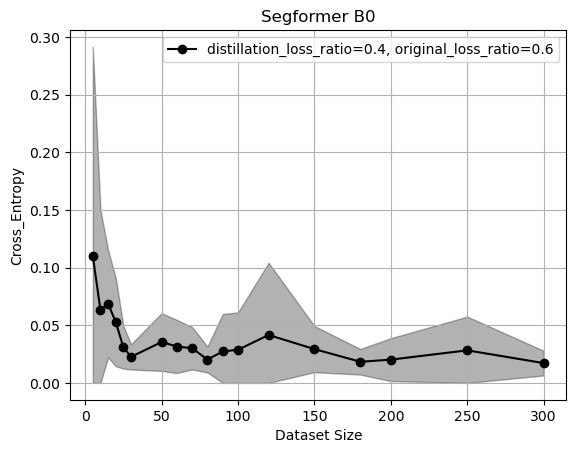

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()